In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from Model import Classifier
import torch
from PIL import Image
import torchvision.transforms as T

In [ ]:
def visualize_activations(model, device, test_image_path, selected_channels):
    transform = T.Compose([
        T.Resize((128, 128)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(test_image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(device)

    activations = []
    
    def hook_fn(module, input, output):
        activations.append(output.detach().cpu())
    
    hooks = []
    blocks = [
        model.block1, model.block2,
        model.block3, model.block4,
        model.block5, model.block6
    ]
        
    for block in blocks:
        hooks.append(block.register_forward_hook(hook_fn))
    
    with torch.no_grad():
        _ = model(img_tensor)
    
    for hook in hooks:
        hook.remove()

    fig = plt.figure(figsize=(20, 15))
    columns = 4
    rows = 2
    
    for i, act in enumerate(activations):
    
        ch_idx = selected_channels[i]
        num_channels = act.shape[1]
        
    
        if ch_idx >= num_channels:
            ch_idx = num_channels - 1
            print(f"Предупреждение: Блок {i+1} имеет только {num_channels} каналов. Используется канал {ch_idx}.")
        elif ch_idx < 0:
            ch_idx = 0
            print(f"Предупреждение: Отрицательный индекс канала. Используется канал 0.")
        
    
        channel_data = act[0, ch_idx, :, :].unsqueeze(0) 
        channels = channel_data.repeat(3, 1, 1) 
        
        channels = channels * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        channels = channels + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        channels = torch.clamp(channels, 0, 1)
        
        ax = fig.add_subplot(rows, columns, i+1)
        ax.set_title(f'Блок {i+1}\nКанал {ch_idx} | Размер: {act.shape[2:]}')
        plt.imshow(make_grid(channels, nrow=1).permute(1, 2, 0))
    
    plt.tight_layout()
    plt.show()



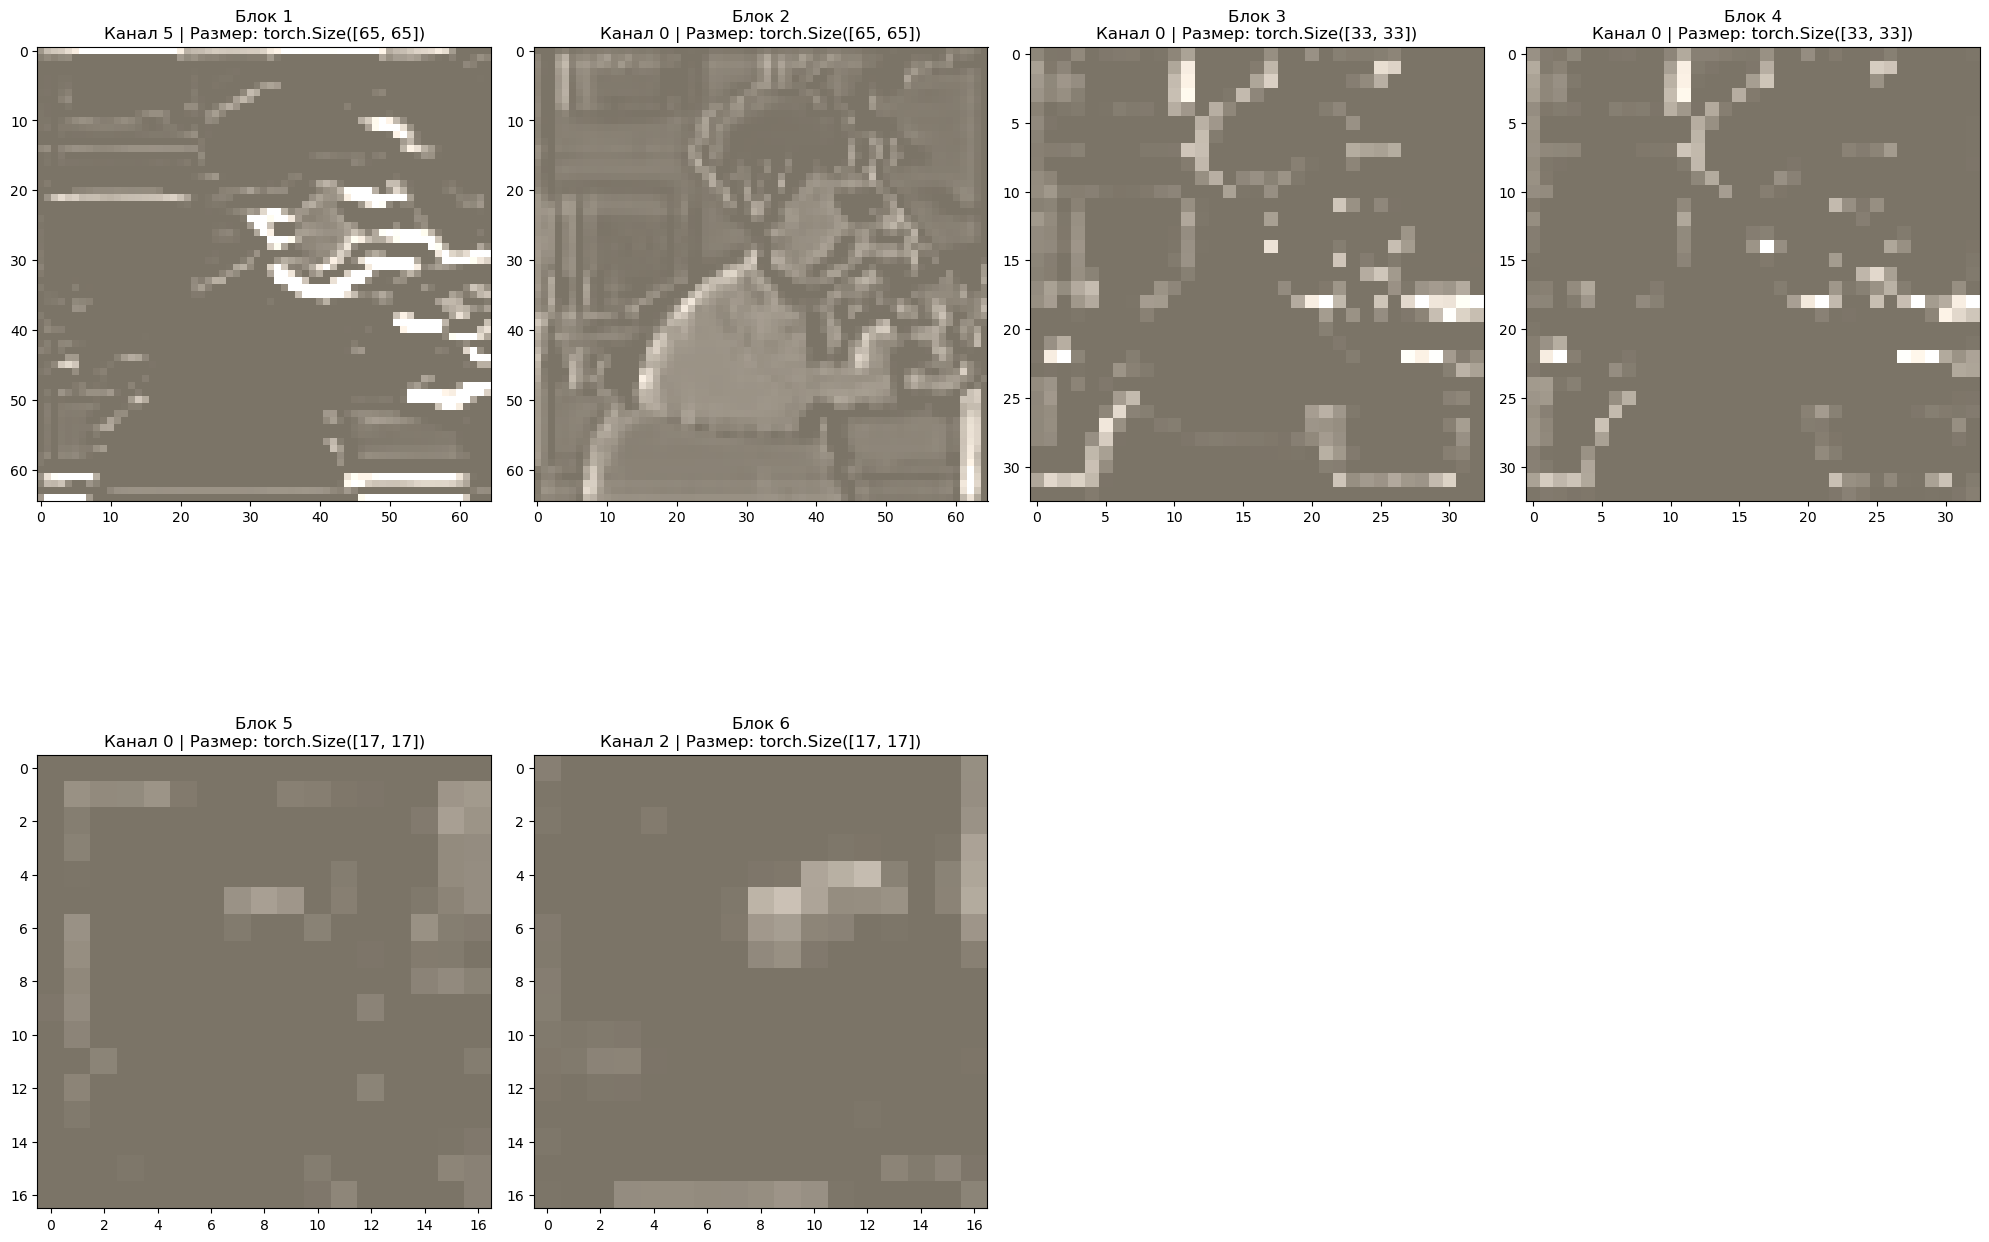

In [ ]:
classifier = Classifier('cpu')
classifier.load_model("../meta_data/best.tar")

path = "../dataset/val/agnes_skinner/pic_0018.jpg"

selected_channels = [5, 0, 0, 0, 0, 2]

visualize_activations(classifier.model, 'cpu', path, selected_channels)